# The Battle of Neighborhoods - Part 2

### Intro

The United States of America is one of the countries with the highest rate of obesity in the world, both for adults and for children. It is estimated that about 71% of the American population over 15 years of age is obese or overweight. In children, the situation is more serious since the obesity rate is 43%, the highest value worldwide.
An OECD report published in 2019 highlights obesity as an important risk factor for many chronic diseases, including diabetes, cardiovascular disease and cancer.

To promote a decrease in these values, it is necessary to implement some changes in lifestyle, namely with regard to the consumption of fast food, obesity and physical inactivity. Gyms are one of the “weapons” to combat these aspects, since they promote healthy eating habits and physical activity.

Having said that, and taking New York City as a sample, I intend to get an answer to the following problems:

    - Compare the number of Fast Food restaurants with the number of Gyms in the different boroughs of New York;
    - What are the neighborhoods with higher/less number of gyms?
    - What are the neighborhoods with higher/less number of fast food restaurants?    
    - In how many neighborhoods there are no gyms?
    - What is the best neighborhood to live in if you like going to gyms?
    - What is the best neighborhood to open a new gym?

### Imports

In [1]:
import urllib.request # import the library we use to open URLs
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
#!pip install BeautifulSoup4 # If don't have the library
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import seaborn as sns

### Get the data

In [2]:
address = 'New York, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data= new_york_data.append({'Borough': borough,'Neighborhood': neighborhood_name,'Latitude': neighborhood_lat,'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [4]:
new_york_data=get_new_york_data()

In [5]:
new_york_data

Borough  Neighborhood   Latitude  Longitude
0            Bronx     Wakefield  40.894705 -73.847201
1            Bronx    Co-op City  40.874294 -73.829939
2            Bronx   Eastchester  40.887556 -73.827806
3            Bronx     Fieldston  40.895437 -73.905643
4            Bronx     Riverdale  40.890834 -73.912585
..             ...           ...        ...        ...
301      Manhattan  Hudson Yards  40.756658 -74.000111
302         Queens       Hammels  40.587338 -73.805530
303         Queens     Bayswater  40.611322 -73.765968
304         Queens  Queensbridge  40.756091 -73.945631
305  Staten Island     Fox Hills  40.617311 -74.081740

[306 rows x 4 columns]

In [6]:
new_york_data.shape

(306, 4)

### Exploratory Analysis 

##### In this section we will explore the data from New York neighbors, more specifically regarding the fact of having gyms and fast food restaurants.

First let's create a bar plot to show the how many neighbors the different boroughs in New York have.

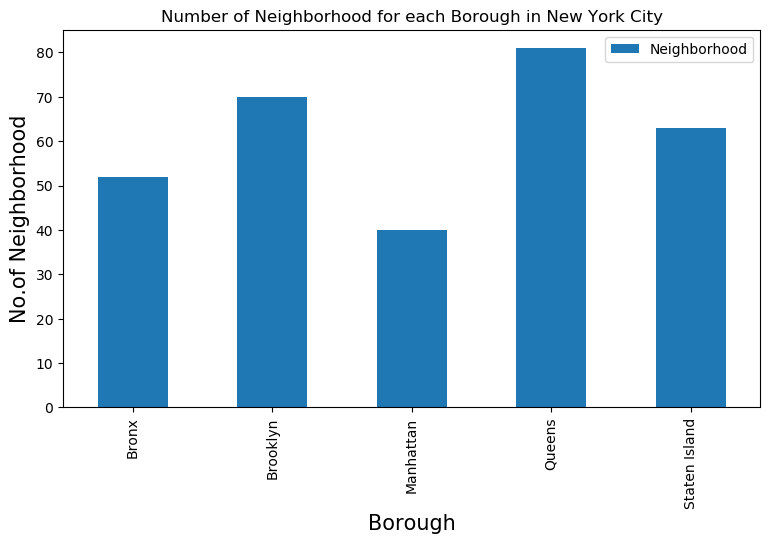

In [7]:
plt.figure(figsize=(9,5), dpi = 100)

#title
plt.title('Number of Neighborhood for each Borough in New York City')

#On x-axis
plt.xlabel('Borough', fontsize = 15)

#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)

#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')

#legend
plt.legend()

#displays the plot
plt.show()

Now, let's map this neighbors geographically.

In [8]:
# create map using latitude and longitude values
mapping = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, Neighbourhood in zip(new_york_data['Latitude'], new_york_data['Longitude'],new_york_data['Borough'], new_york_data['Neighborhood']):
    label = '{}, {}'.format(Neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapping) 

In [9]:
mapping

In [10]:
new_york_data['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

From the above analysis, we can see that Queens is the borough that has highest number of neighborhoods. 

##### In order to get more information regarding the neighborhoods, we need to add to the initial dataset valuable information about the points of interest in each of them. We do that by using the Foursquare API

Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'XKPMOXP0WTCT1PKBVAOSP0VFSCCGCRVAYTJARZ0YRIBFCPYZ' # your Foursquare ID
CLIENT_SECRET = 'EMWPMLLSNF41LYFKRWJPDUCXU0M0SF243OCJHOJW20C13E3Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XKPMOXP0WTCT1PKBVAOSP0VFSCCGCRVAYTJARZ0YRIBFCPYZ
CLIENT_SECRET:EMWPMLLSNF41LYFKRWJPDUCXU0M0SF243OCJHOJW20C13E3Z


We define a function to intract with FourSquare API and get top 500 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
ny_venues = getNearbyVenues(names=new_york_data['Neighborhood'],
                                   latitudes=new_york_data['Latitude'],
                                   longitudes=new_york_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [14]:
print(ny_venues.shape)
ny_venues.head()

(20587, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                         Venue  Venue Latitude  Venue Longitude  \
0             Lollipops Gelato       40.894123       -73.845892   
1           Ripe Kitchen & Bar       40.898152       -73.838875   
2              Ali's Roti Shop       40.894036       -73.856935   
3             Carvel Ice Cream       40.890487       -73.848568   
4  Jackie's West Indian Bakery       40.889283       -73.843310   

         Venue Category  
0          Dessert Shop  
1  Caribbean Restaurant  
2  Caribbean Restaurant  
3        Ice Cream Shop  
4  Caribbean Restaurant

In [15]:
ny_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                          
Allerton                          72                      72     72   
Annadale                          19                      19     19   
Arden Heights                     24                      24     24   
Arlington                         23                      23     23   
Arrochar                          29                      29     29   
...                              ...                     ...    ...   
Woodhaven                         67                      67     67   
Woodlawn                          48                      48     48   
Woodrow                           20                      20     20   
Woodside                         100                     100    100   
Yorkville                        100                     100    100   

               Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                    
Allerton                   72               72              72  
Annadale                   19               19              19  
Arden Heights              24               24              24  
Arlington                  23               23              23  
Arrochar                   29               29              29  
...                       ...              ...             ...  
Woodhaven                  67               67              67  
Woodlawn                   48               48              48  
Woodrow                    20               20              20  
Woodside                  100              100             100  
Yorkville                 100              100             100  

[302 rows x 6 columns]

In [16]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 477 uniques categories.


Count the number of points of interest by category.

In [17]:
ny_venues['Venue Category'].value_counts()

Pizza Place                 1046
Coffee Shop                  550
Italian Restaurant           528
Deli / Bodega                486
Donut Shop                   459
                            ... 
National Park                  1
Physical Therapist             1
College Basketball Court       1
ATM                            1
Kofte Place                    1
Name: Venue Category, Length: 477, dtype: int64

We need to get from the dataset all the points of interest related to the general category gym and fast food restaurant because for making the analysis easier we should have it in a unique column (a column for all the categories that are gym and a column for all the categories that are fast food restaurants). Let's see all the unique existing categories.

In [18]:
ny_venues['Venue Category'].unique()

array(['Dessert Shop', 'Caribbean Restaurant', 'Ice Cream Shop',
       'Burger Joint', 'Donut Shop', 'Pharmacy', 'Sandwich Place',
       'Gas Station', 'Bakery', 'Mobile Phone Shop',
       'Fried Chicken Joint', 'Supermarket', 'Pizza Place', 'Bank',
       'Fast Food Restaurant', 'Food Truck', 'Chinese Restaurant',
       'Asian Restaurant', 'Food', 'Bagel Shop', 'Metro Station',
       'Check Cashing Service', 'Deli / Bodega', 'Park',
       'Dumpling Restaurant', 'Spanish Restaurant', 'Seafood Restaurant',
       'Discount Store', 'Mexican Restaurant', 'Shopping Mall',
       'Kids Store', 'BBQ Joint', 'Shoe Store', 'Mattress Store',
       'Furniture / Home Store', 'Coffee Shop', 'Video Game Store',
       'Paper / Office Supplies Store', 'Grocery Store', 'Movie Theater',
       'Department Store', 'Convenience Store', 'Accessories Store',
       'Nightclub', 'Restaurant', 'Miscellaneous Shop', "Women's Store",
       'American Restaurant', 'Bus Station', 'Baseball Field',
      

Next, we can see that many categories related to gyms and fast food restaurants were found. We need to deal with it later.

In [19]:
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Fast Food Restaurant'].value_counts())
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Gym'].value_counts())
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Pizza Place'].value_counts())
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Gym / Fitness Center'].value_counts())
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Sports Club'].value_counts())
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Gym Pool'].value_counts())
print (ny_venues['Venue Category'][ny_venues['Venue Category']=='Pilates Studio'].value_counts())

Fast Food Restaurant    267
Name: Venue Category, dtype: int64
Gym    271
Name: Venue Category, dtype: int64
Pizza Place    1046
Name: Venue Category, dtype: int64
Gym / Fitness Center    232
Name: Venue Category, dtype: int64
Sports Club    8
Name: Venue Category, dtype: int64
Gym Pool    5
Name: Venue Category, dtype: int64
Pilates Studio    17
Name: Venue Category, dtype: int64


### Analyzing each neighbour

We have a categorical variable named 'Venue Category' that is related to the most valuable information in this dataset. Our analysis won't be rich if we don't transform it into a numerical variable (or many) in order to perform some calculation. What is present next is the transformation of the categorical column in many numerical columns (equal to the total number of unique categories).

In [20]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_venues.columns[0]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield    0                  0               0                  0   
1    Wakefield    0                  0               0                  0   
2    Wakefield    0                  0               0                  0   
3    Wakefield    0                  0               0                  0   
4    Wakefield    0                  0               0                  0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  ...  Waterfront  Weight Loss Center  Whisky Bar  \
0                    0  ...           0                   0           0   
1                    0  ...           0                   0           0   
2                    0  ...           0                   0           0   
3                    0  ...           0                   0           0   
4                    0  ...           0                   0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  
0         0          0       0            0              0            0    0  
1         0          0       0            0              0            0    0  
2         0          0       0            0              0            0    0  
3         0          0       0            0              0            0    0  
4         0          0       0            0              0            0    0  

[5 rows x 477 columns]

In [21]:
ny_onehot=ny_onehot.iloc[:,1:]

In [22]:
ny_onehot['Neighborhood']

0        Wakefield
1        Wakefield
2        Wakefield
3        Wakefield
4        Wakefield
           ...    
20582    Fox Hills
20583    Fox Hills
20584    Fox Hills
20585    Fox Hills
20586    Fox Hills
Name: Neighborhood, Length: 20587, dtype: object

##### Grouping the rows by neighborhood by taking the frequency of occurrence of each category

In [23]:
ny_grouped = ny_onehot.groupby(['Neighborhood']).sum().reset_index()
ny_grouped

Neighborhood  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0         Allerton    0                  0               0                  0   
1         Annadale    0                  0               0                  0   
2    Arden Heights    0                  0               0                  0   
3        Arlington    0                  0               0                  0   
4         Arrochar    0                  0               0                  0   
..             ...  ...                ...             ...                ...   
297      Woodhaven    0                  0               0                  0   
298       Woodlawn    0                  0               0                  0   
299        Woodrow    0                  0               0                  0   
300       Woodside    0                  0               0                  0   
301      Yorkville    0                  0               0                  0   

     African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                     0               0                0                 0   
1                     0               0                0                 0   
2                     0               0                0                 0   
3                     0               0                0                 0   
4                     0               0                0                 0   
..                  ...             ...              ...               ...   
297                   0               0                0                 0   
298                   0               0                0                 0   
299                   0               0                0                 0   
300                   0               0                0                 0   
301                   0               0                0                 0   

     American Restaurant  ...  Waterfront  Weight Loss Center  Whisky Bar  \
0                      1  ...           0                   0           0   
1                      1  ...           0                   0           0   
2                      0  ...           0                   0           0   
3                      1  ...           0                   0           0   
4                      0  ...           0                   0           0   
..                   ...  ...         ...                 ...         ...   
297                    2  ...           0                   0           0   
298                    1  ...           0                   0           0   
299                    0  ...           0                   0           0   
300                    5  ...           0                   0           0   
301                    1  ...           0                   0           0   

     Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  
0           0          0       0            0              0            0    0  
1           0          0       0            0              0            0    0  
2           0          0       0            0              0            0    0  
3           0          0       0            1              0            0    0  
4           0          0       0            0              0            0    0  
..        ...        ...     ...          ...            ...          ...  ...  
297         0          0       0            0              0            0    0  
298         0          0       0            0              0            0    0  
299         0          0       0            0              0            0    0  
300         0          0       0            0              0            0    0  
301         1          3       0            0              0            3    0  

[302 rows x 476 columns]

As we saw before we have many types of fast food restaurants and gyms. We need to ensure that they are all grouped in the same category in order to explore the neighborhoods with the certain characteristics of the two categories: Gyms and Fast Food Restaurant.

Fast Food Restaurant = Fast Food Restaurant + Pizza Place    
Gym = Gym / Fitness Center + Sports Club + Gym Pool + Pilates Studio 

In [24]:
ny_grouped['Gym'] = ny_grouped['Gym / Fitness Center']+ny_grouped['Sports Club']+ny_grouped['Gym Pool']+ny_grouped['Pilates Studio']
ny_grouped['Fast Food']=ny_grouped['Fast Food Restaurant']+ny_grouped['Pizza Place']
ny_grouped = ny_grouped.drop(['Fast Food Restaurant','Pizza Place','Gym / Fitness Center','Sports Club','Gym Pool','Pilates Studio'], axis=1)

In [25]:
ny_grouped[['Neighborhood','Fast Food']]

Neighborhood  Fast Food
0         Allerton          9
1         Annadale          3
2    Arden Heights          1
3        Arlington          2
4         Arrochar          2
..             ...        ...
297      Woodhaven         10
298       Woodlawn          4
299        Woodrow          0
300       Woodside          3
301      Yorkville          4

[302 rows x 2 columns]

In [26]:
ny_grouped[['Neighborhood','Gym']]

Neighborhood  Gym
0         Allerton    0
1         Annadale    0
2    Arden Heights    0
3        Arlington    0
4         Arrochar    0
..             ...  ...
297      Woodhaven    0
298       Woodlawn    0
299        Woodrow    0
300       Woodside    1
301      Yorkville    2

[302 rows x 2 columns]

##### Top 10 neighborhoods with gyms

In [27]:
ny_grouped[['Neighborhood','Gym']].sort_values('Gym',ascending=False).head(10)

Neighborhood  Gym
97             Flatiron   11
175       Midtown South    6
153      Lincoln Square    6
57              Clinton    6
135        Hudson Yards    6
267        Sutton Place    6
95   Financial District    5
137       Hunters Point    5
151          Lenox Hill    5
43        Carnegie Hill    4

Text(0.5, 1.0, 'Top 10 neighborhoods with gyms')

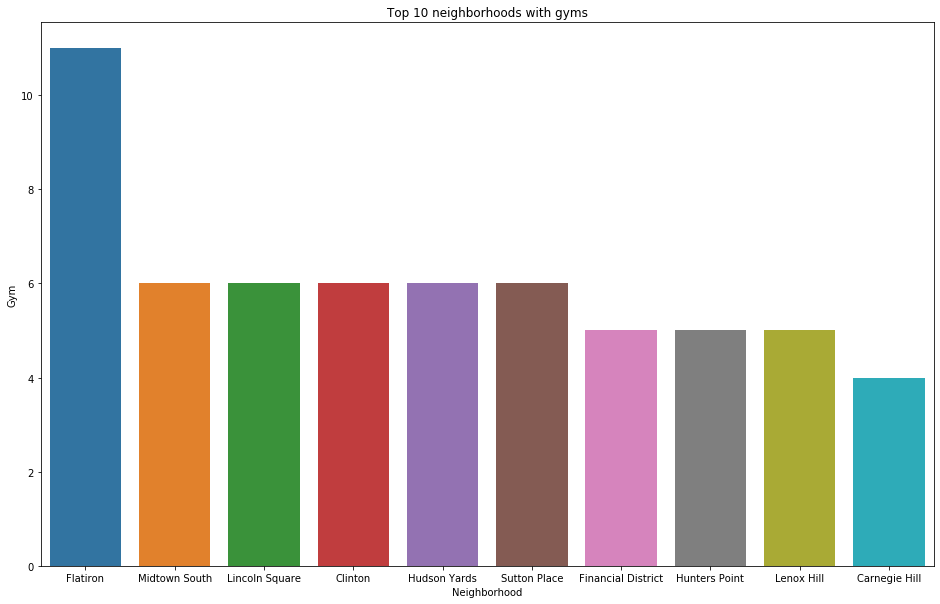

In [28]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="Neighborhood",y='Gym',data=ny_grouped[['Neighborhood','Gym']].sort_values('Gym',ascending=False).head(10))
plt.title('Top 10 neighborhoods with gyms')

##### Neighborhoods with less number of gyms

In [29]:
ny_grouped[['Neighborhood','Gym']].sort_values('Gym',ascending=True).head(10)

Neighborhood  Gym
0             Allerton    0
232          Ridgewood    0
115       Graniteville    0
116         Grant City    0
230      Richmond Town    0
119        Great Kills    0
228     Remsen Village    0
225         Ravenswood    0
122  Greenwich Village    0
123        Grymes Hill    0

From the bar chart shown above, we can see that Flatiron is the neighborhood with the largest number of gyms, ten in total

##### Top 10 neighborhoods with Fast Food restaurants

In [30]:
ny_grouped[['Neighborhood','Fast Food']].sort_values('Fast Food',ascending=False).head(10)

Neighborhood  Fast Food
34        Bronxdale         15
203       Olinville         14
28     Borough Park         12
80     East Tremont         12
9        Bath Beach         12
30        Briarwood         11
292  Williamsbridge         11
52        City Line         11
181     Morris Park         11
182      Morrisania         11

In [31]:
ny_grouped[['Neighborhood','Fast Food']].sort_values('Fast Food',ascending=True).head(10)

Neighborhood  Fast Food
245       Sea Gate          0
273        Tribeca          0
272         Travis          0
40    Butler Manor          0
49         Chelsea          0
55    Clason Point          0
269      Todt Hill          0
57         Clinton          0
252    South Beach          0
77   East Flatbush          0

Text(0.5, 1.0, 'Top 10 neighborhoods with Fast Food restaurants')

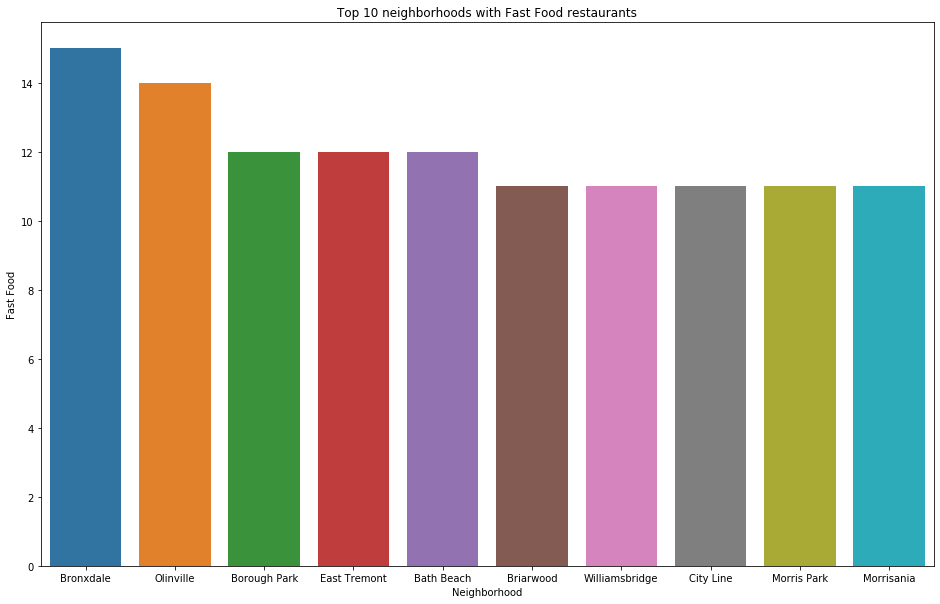

In [32]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="Neighborhood",y='Fast Food',data=ny_grouped[['Neighborhood','Fast Food']].sort_values('Fast Food',ascending=False).head(10))
plt.title('Top 10 neighborhoods with Fast Food restaurants')

From the bar chart shown above, we can see that Bronxdale is the neighborhood with the largest number of fast food restaurants, fifteen in total.

##### Let's see how many gyms exist in the top 10 neighborhood with highest number of fast food restaurants

In [33]:
ny_grouped[['Neighborhood','Fast Food','Gym']].sort_values('Fast Food',ascending=False).head(10)

Neighborhood  Fast Food  Gym
34        Bronxdale         15    0
203       Olinville         14    1
28     Borough Park         12    0
80     East Tremont         12    1
9        Bath Beach         12    1
30        Briarwood         11    0
292  Williamsbridge         11    0
52        City Line         11    0
181     Morris Park         11    1
182      Morrisania         11    1

The table above illustrates the contrast that exists between the number of fast food restaurants and the number of gyms.

##### Let's see what are the neighborhoods where the number of gyms is superior to the number of fast food restaurants

In [34]:
ny_grouped[['Neighborhood','Fast Food', 'Gym']][ny_grouped['Gym']>ny_grouped['Fast Food']].sort_values('Gym',ascending=False)

Neighborhood  Fast Food  Gym
97             Flatiron          2   11
135        Hudson Yards          2    6
267        Sutton Place          2    6
175       Midtown South          4    6
153      Lincoln Square          1    6
57              Clinton          0    6
137       Hunters Point          1    5
151          Lenox Hill          3    5
95   Financial District          2    5
278     Upper East Side          1    4
102        Forest Hills          1    4
43        Carnegie Hill          3    4
10    Battery Park City          2    3
73             Downtown          2    3
53         Civic Center          1    3
49              Chelsea          0    3
48           Charleston          1    3
272              Travis          0    2
55         Clason Point          0    1
273             Tribeca          0    1
275          Turtle Bay          0    1
282        Vinegar Hill          0    1

How many neighborhoods have more gyms than fast food restaurants?

In [35]:
len(ny_grouped[['Neighborhood','Fast Food', 'Gym']][ny_grouped['Gym']>ny_grouped['Fast Food']].sort_values('Gym',ascending=False))

22

How many neighborhood there is?

In [36]:
len(ny_grouped)

302

So, in 302 neighborhoods only in 20 of them the number of gyms is superior to the number of fast food restaurant

How many neighborhoods don't have any gyms?

In [37]:
len(ny_grouped[['Neighborhood','Fast Food', 'Gym']][ny_grouped['Gym']==0])

157

And, even more shocking from the 302 neighborhoods there are 157 neighbourhoods that don't have gyms.

How many neighborhoods don't have any Fast Food restaurants?

In [128]:
len(ny_grouped[['Neighborhood','Fast Food', 'Gym']][ny_grouped['Fast Food']==0])

23

##### Let's see where the neighbors with gyms and without gyms are located. The neighbors that doesn't have gyms are close to neighbors that have gyms?

Get latitude and longitude from neighbors

In [41]:
merged_ny=pd.merge(ny_grouped[['Neighborhood','Gym','Fast Food']],ny_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']].drop_duplicates(),on='Neighborhood')

Create a bool column that is 0 if the neighbor don't have gyms and 1 if the neighbor have gyms.

In [42]:
merged_ny['bool_gym']=merged_ny['Gym'] 
merged_ny['bool_gym'][merged_ny['Gym'] == 0] = 0
merged_ny['bool_gym'][merged_ny['Gym'] != 0] = 1
merged_ny

/Users/diogoquintao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/diogoquintao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Neighborhood  Gym  Fast Food  Neighborhood Latitude  \
0         Allerton    0          9              40.865788   
1         Annadale    0          3              40.538114   
2    Arden Heights    0          1              40.549286   
3        Arlington    0          2              40.635325   
4         Arrochar    0          2              40.596313   
..             ...  ...        ...                    ...   
301      Woodhaven    0         10              40.689887   
302       Woodlawn    0          4              40.898273   
303        Woodrow    0          0              40.541968   
304       Woodside    1          3              40.746349   
305      Yorkville    2          4              40.775930   

     Neighborhood Longitude  bool_gym  
0                -73.859319         0  
1                -74.178549         0  
2                -74.185887         0  
3                -74.165104         0  
4                -74.067124         0  
..                      ...       ...  
301              -73.858110         0  
302              -73.867315         0  
303              -74.205246         0  
304              -73.901842         1  
305              -73.947118         1  

[306 rows x 6 columns]

Map geographically the neighbors. In purple we can visualize all the neighbors that have gyms and in red all the neighborhoods that don't have gyms.

In [43]:
# create map
map_categories = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, bool_gym in zip(merged_ny['Neighborhood Latitude'], merged_ny['Neighborhood Longitude'], merged_ny['Neighborhood'], merged_ny['bool_gym']):
    label = folium.Popup(str(poi) + ' Have gym ' + str(bool_gym), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[bool_gym-1],
        fill=True,
        fill_color=rainbow[bool_gym-1],
        fill_opacity=0.7).add_to(map_categories)


map_categories

We can conclude that close to the center of NY there is a higher number of neighborhoods with gyms (purple points) and close to the periphery there is a lower number of neighborhoods with gyms (red points). We also see that are some neighbors that don't have gyms and aren't near to any neighbor that have gyms, specially in Staten Island and close to the sea.

### Analyzing each borough

To get the points of interest by borough we need to merge the new_york_data dataframe with the ny_venues dataframe.

In [44]:
merged_ny_borough=pd.merge(new_york_data[['Borough','Neighborhood']],ny_venues[['Neighborhood','Venue','Venue Latitude','Venue Longitude','Venue Category']].drop_duplicates(),on='Neighborhood')
merged_ny_borough

Borough Neighborhood                        Venue  \
0              Bronx    Wakefield             Lollipops Gelato   
1              Bronx    Wakefield           Ripe Kitchen & Bar   
2              Bronx    Wakefield              Ali's Roti Shop   
3              Bronx    Wakefield             Carvel Ice Cream   
4              Bronx    Wakefield  Jackie's West Indian Bakery   
...              ...          ...                          ...   
21138  Staten Island    Fox Hills                     Al-Humza   
21139  Staten Island    Fox Hills             Kum Fung Kitchen   
21140  Staten Island    Fox Hills              The Coffeehouse   
21141  Staten Island    Fox Hills                    Starbucks   
21142  Staten Island    Fox Hills            MTA SIR - Clifton   

       Venue Latitude  Venue Longitude        Venue Category  
0           40.894123       -73.845892          Dessert Shop  
1           40.898152       -73.838875  Caribbean Restaurant  
2           40.894036       -73.856935  Caribbean Restaurant  
3           40.890487       -73.848568        Ice Cream Shop  
4           40.889283       -73.843310  Caribbean Restaurant  
...               ...              ...                   ...  
21138       40.611311       -74.088900     Indian Restaurant  
21139       40.621842       -74.072305    Chinese Restaurant  
21140       40.614638       -74.092345                  Café  
21141       40.615535       -74.092930           Coffee Shop  
21142       40.621543       -74.071498         Train Station  

[21143 rows x 6 columns]

Again, we need to transform the categorical variable 'Venue Category' in many numerical variables (equal to the total number of unique categories).

In [45]:
# one hot encoding
ny_onehot2 = pd.get_dummies(merged_ny_borough[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot2['Borough'] = merged_ny_borough['Borough'] 

# move neighborhood column to the first column
#fixed_columns = [merged_ny_borough[1]] + list(ny_onehot2.columns[:-1])
#ny_onehot2 = ny_onehot2[fixed_columns]

ny_onehot2.head()

ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    0                  0               0                  0   
1    0                  0               0                  0   
2    0                  0               0                  0   
3    0                  0               0                  0   
4    0                  0               0                  0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Amphitheater  ...  Whisky Bar  Wine Bar  Wine Shop  \
0                    0             0  ...           0         0          0   
1                    0             0  ...           0         0          0   
2                    0             0  ...           0         0          0   
3                    0             0  ...           0         0          0   
4                    0             0  ...           0         0          0   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  Borough  
0       0            0              0            0    0            0    Bronx  
1       0            0              0            0    0            0    Bronx  
2       0            0              0            0    0            0    Bronx  
3       0            0              0            0    0            0    Bronx  
4       0            0              0            0    0            0    Bronx  

[5 rows x 478 columns]

And again, create the two variables gym and fast food restaurant agregating the information of all the variables related to gyms and fast food restaurants.

In [46]:
ny_onehot2['Gym'] = ny_onehot2['Gym / Fitness Center']+ny_onehot2['Sports Club']+ny_onehot2['Gym Pool']+ny_onehot2['Pilates Studio']
ny_onehot2['Fast Food']=ny_onehot2['Fast Food Restaurant']+ny_onehot2['Pizza Place']
ny_onehot2 = ny_onehot2.drop(['Fast Food Restaurant','Pizza Place','Gym / Fitness Center','Sports Club','Gym Pool','Pilates Studio'], axis=1)

In [47]:
ny_boroughs = ny_onehot2.groupby(['Borough']).sum().reset_index()
ny_boroughs

Borough  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0          Bronx  0.0                3.0             0.0                0.0   
1       Brooklyn  0.0                4.0             0.0                0.0   
2      Manhattan  0.0                1.0             1.0                0.0   
3         Queens  1.0                5.0             0.0                3.0   
4  Staten Island  0.0                5.0             0.0                0.0   

   African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                 5.0             0.0              0.0               0.0   
1                 2.0             0.0              0.0               0.0   
2                 5.0             0.0              0.0               0.0   
3                 0.0             3.0             10.0               2.0   
4                 0.0             1.0              0.0               0.0   

   American Restaurant  ...  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0                 33.0  ...         0.0       0.0        8.0     0.0   
1                 78.0  ...         4.0      23.0       67.0     1.0   
2                 92.0  ...         6.0      39.0       63.0     0.0   
3                 57.0  ...         0.0      14.0       20.0     0.0   
4                 48.0  ...         0.0       0.0        7.0     0.0   

   Wings Joint  Women's Store  Yoga Studio   Zoo  Zoo Exhibit  Fast Food  
0          8.0            7.0          4.0  12.0          5.0      347.0  
1          5.0            9.0         69.0   0.0          0.0      354.0  
2          4.0           11.0         50.0   0.0          0.0      121.0  
3          9.0            5.0         17.0   1.0          0.0      341.0  
4         11.0           10.0          5.0   0.0          0.0      174.0  

[5 rows x 473 columns]

##### Top boroughs with gyms

In [48]:
ny_boroughs[['Borough','Gym']].sort_values('Gym',ascending=False)

Borough   Gym
2      Manhattan  91.0
1       Brooklyn  68.0
3         Queens  58.0
4  Staten Island  29.0
0          Bronx  26.0

Text(0.5, 1.0, 'Top boroughs in NY city with gyms')

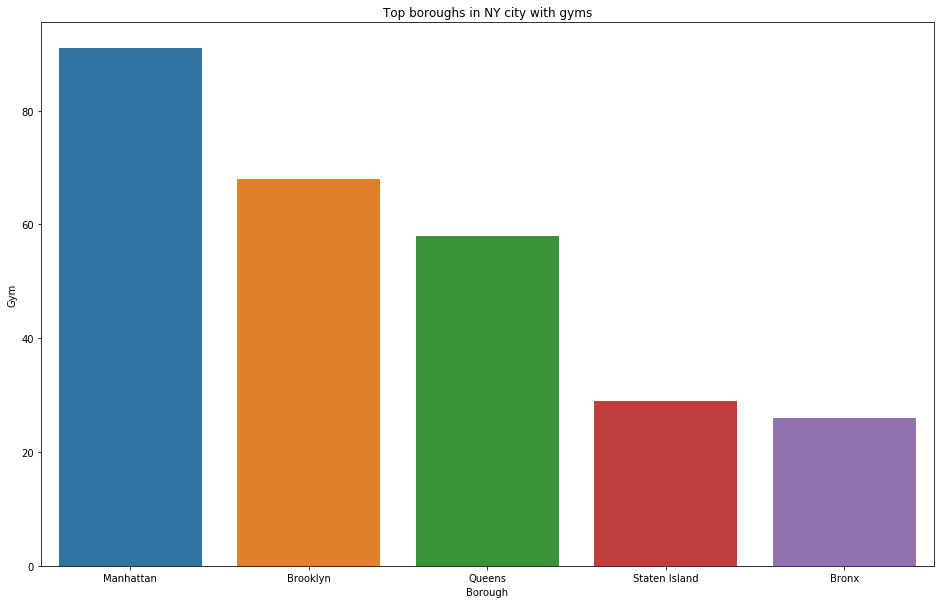

In [49]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="Borough",y='Gym',data=ny_boroughs[['Borough','Gym']].sort_values('Gym',ascending=False))
plt.title('Top boroughs in NY city with gyms')

From the graph above, we can see that the Borough with the largest number of gyms is Manhattan, with a total of 97 gyms.

##### Top boroughs with Fast Food restaurants

In [50]:
ny_boroughs[['Borough','Fast Food']].sort_values('Fast Food',ascending=False)

Borough  Fast Food
1       Brooklyn      354.0
0          Bronx      347.0
3         Queens      341.0
4  Staten Island      174.0
2      Manhattan      121.0

Text(0.5, 1.0, 'Top boroughs in NY City with Fast Food')

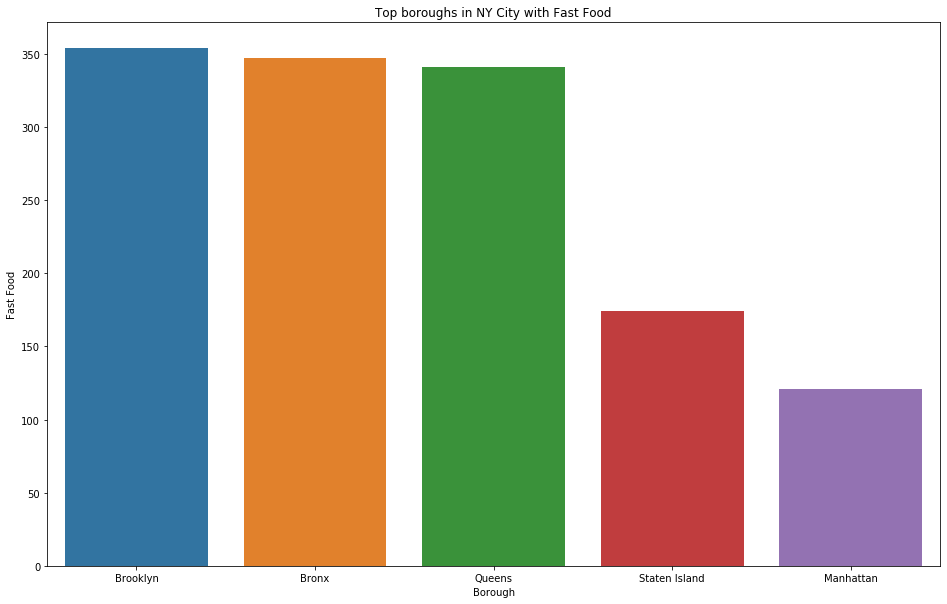

In [51]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="Borough",y='Fast Food',data=ny_boroughs[['Borough','Fast Food']].sort_values('Fast Food',ascending=False))
plt.title('Top boroughs in NY City with Fast Food')

In terms of fast food restaurants, Brooklyn is the Borough with the highest number, 347 in total and Manhattan is the borough with less number of fast food restaurants which is a good finding because it was the borough with highest number of gyms. The Bronx case is more critical because is one of the boroughs with higher number of fast food restaurants but is the borough with less number of gyms.

#### Comparison of the number of restaurants with the number of gyms by Borough

In [52]:
ny_boroughs[['Borough','Fast Food','Gym']].sort_values('Fast Food',ascending=False)

Borough  Fast Food   Gym
1       Brooklyn      354.0  68.0
0          Bronx      347.0  26.0
3         Queens      341.0  58.0
4  Staten Island      174.0  29.0
2      Manhattan      121.0  91.0

We can see that the number of gyms is much lower than the number of fast food restaurants. In the Bronx the proportion is one gym for twelve fast food restaurants.

##### Map all fast food restaurants and gyms in NY city

In [53]:
merged_ny_borough['Venue Category'][merged_ny_borough['Venue Category']=='Gym / Fitness Center']='Gym'
merged_ny_borough['Venue Category'][merged_ny_borough['Venue Category']=='Sports Club']='Gym'
merged_ny_borough['Venue Category'][merged_ny_borough['Venue Category']=='Gym Pool']='Gym'
merged_ny_borough['Venue Category'][merged_ny_borough['Venue Category']=='Pilates Studio']='Gym'
merged_ny_borough['Venue Category'][merged_ny_borough['Venue Category']=='Fast Food Restaurant']='Fast Food'
merged_ny_borough['Venue Category'][merged_ny_borough['Venue Category']=='Pizza Place']='Fast Food'

/Users/diogoquintao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/diogoquintao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/diogoquintao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [54]:
merged_ny_borough

Borough Neighborhood                        Venue  \
0              Bronx    Wakefield             Lollipops Gelato   
1              Bronx    Wakefield           Ripe Kitchen & Bar   
2              Bronx    Wakefield              Ali's Roti Shop   
3              Bronx    Wakefield             Carvel Ice Cream   
4              Bronx    Wakefield  Jackie's West Indian Bakery   
...              ...          ...                          ...   
21138  Staten Island    Fox Hills                     Al-Humza   
21139  Staten Island    Fox Hills             Kum Fung Kitchen   
21140  Staten Island    Fox Hills              The Coffeehouse   
21141  Staten Island    Fox Hills                    Starbucks   
21142  Staten Island    Fox Hills            MTA SIR - Clifton   

       Venue Latitude  Venue Longitude        Venue Category  
0           40.894123       -73.845892          Dessert Shop  
1           40.898152       -73.838875  Caribbean Restaurant  
2           40.894036       -73.856935  Caribbean Restaurant  
3           40.890487       -73.848568        Ice Cream Shop  
4           40.889283       -73.843310  Caribbean Restaurant  
...               ...              ...                   ...  
21138       40.611311       -74.088900     Indian Restaurant  
21139       40.621842       -74.072305    Chinese Restaurant  
21140       40.614638       -74.092345                  Café  
21141       40.615535       -74.092930           Coffee Shop  
21142       40.621543       -74.071498         Train Station  

[21143 rows x 6 columns]

In [55]:
df_fastfood_gym=merged_ny_borough[(merged_ny_borough['Venue Category']=='Fast Food') | (merged_ny_borough['Venue Category']=='Gym')]
df_fastfood_gym

Borough  Neighborhood                    Venue  Venue Latitude  \
17      Bronx     Wakefield           Domino's Pizza       40.898443   
22      Bronx     Wakefield               McDonald's       40.902645   
24      Bronx     Wakefield               McDonald's       40.892779   
26      Bronx     Wakefield               McDonald's       40.891376   
29      Bronx     Wakefield              Louis Pizza       40.898399   
...       ...           ...                      ...             ...   
21046  Queens  Queensbridge  Linc LIC Fitness Center       40.748921   
21062  Queens  Queensbridge                  Luzzo’s       40.748949   
21095  Queens  Queensbridge    GoodFellas Pizza Inc.       40.753242   
21099  Queens  Queensbridge              MetLife Gym       40.750340   
21101  Queens  Queensbridge     Orangetheory Fitness       40.747748   

       Venue Longitude Venue Category  
17          -73.854851      Fast Food  
22          -73.849485      Fast Food  
24          -73.857473      Fast Food  
26          -73.851632      Fast Food  
29          -73.848810      Fast Food  
...                ...            ...  
21046       -73.942679            Gym  
21062       -73.942213      Fast Food  
21095       -73.937256      Fast Food  
21099       -73.939239            Gym  
21101       -73.946975            Gym  

[1887 rows x 6 columns]

In [56]:
# create map
map_categories2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, bool_gym in zip(df_fastfood_gym['Venue Latitude'], df_fastfood_gym['Venue Longitude'], df_fastfood_gym['Borough'], df_fastfood_gym['Venue Category']):
    label = folium.Popup(str(poi) + ' - ' + str(bool_gym), parse_html=True)
    if (bool_gym=='Gym'):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[1-1],
            fill=True,
            fill_color=rainbow[1-1],
            fill_opacity=0.7).add_to(map_categories2)
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[2-1],
            fill=True,
            fill_color=rainbow[2-1],
            fill_opacity=0.7).add_to(map_categories2)


map_categories2

### Clustering

##### Put everything in a dataframe for clustering

In [57]:
num_top_venues = 5

for hood in ny_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                 venue  freq
0            Fast Food   9.0
1          Supermarket   4.0
2   Chinese Restaurant   4.0
3           Donut Shop   4.0
4  Fried Chicken Joint   3.0


----Annadale----
        venue  freq
0   Fast Food   3.0
1      Bakery   2.0
2  Restaurant   2.0
3       Trail   2.0
4        Park   1.0


----Arden Heights----
                        venue  freq
0                    Bus Stop   2.0
1                        Park   2.0
2          Mexican Restaurant   2.0
3                   Fast Food   1.0
4  Construction & Landscaping   1.0


----Arlington----
            venue  freq
0        Bus Stop   3.0
1       Fast Food   2.0
2  Hardware Store   2.0
3   Boat or Ferry   2.0
4  Rental Service   1.0


----Arrochar----
                venue  freq
0      Baseball Field   3.0
1            Bus Stop   3.0
2               Beach   2.0
3           Fast Food   2.0
4  Italian Restaurant   2.0


----Arverne----
           venue  freq
0      Surf Spot   4.0
1          Beac

                       venue  freq
0                  Fast Food   7.0
1                 Donut Shop   4.0
2        Fried Chicken Joint   4.0
3              Grocery Store   3.0
4  Latin American Restaurant   3.0


----Ditmas Park----
                  venue  freq
0  Caribbean Restaurant   8.0
1    Mexican Restaurant   7.0
2             Fast Food   6.0
3           Coffee Shop   4.0
4         Grocery Store   4.0


----Dongan Hills----
                venue  freq
0           Fast Food   8.0
1  Italian Restaurant   7.0
2                Bank   4.0
3      Ice Cream Shop   3.0
4         Flower Shop   2.0


----Douglaston----
                venue  freq
0  Italian Restaurant   5.0
1  Chinese Restaurant   5.0
2           Fast Food   3.0
3                 Spa   3.0
4                Bank   3.0


----Downtown----
           venue  freq
0    Coffee Shop   8.0
1            Bar   4.0
2  Grocery Store   4.0
3            Gym   3.0
4    Yoga Studio   3.0


----Dumbo----
                 venue  freq
0     

        venue  freq
0       Beach   9.0
1   Surf Spot   5.0
2   Fast Food   4.0
3  Taco Place   2.0
4         Bar   2.0


----Heartland Village----
                    venue  freq
0          Clothing Store   6.0
1              Shoe Store   4.0
2                Pharmacy   4.0
3       Accessories Store   4.0
4  Furniture / Home Store   4.0


----High  Bridge----
              venue  freq
0  Baseball Stadium   3.0
1            Lounge   3.0
2              Park   2.0
3             Plaza   2.0
4     Historic Site   2.0


----Highland Park----
                       venue  freq
0                  Fast Food   6.0
1                 Donut Shop   3.0
2             Ice Cream Shop   3.0
3  Latin American Restaurant   3.0
4             Sandwich Place   2.0


----Hillcrest----
               venue  freq
0          Fast Food   6.0
1  Mobile Phone Shop   3.0
2     Sandwich Place   3.0
3     Ice Cream Shop   3.0
4        Bus Station   3.0


----Hollis----
                 venue  freq
0            Fast F

               venue  freq
0          Fast Food   7.0
1      Deli / Bodega   5.0
2             Bakery   4.0
3           Bus Line   3.0
4  Convenience Store   3.0


----Midland Beach----
            venue  freq
0       Fast Food   6.0
1           Beach   4.0
2  Cosmetics Shop   2.0
3  Baseball Field   2.0
4        Bus Stop   2.0


----Midtown----
                 venue  freq
0              Theater   9.0
1                Hotel   6.0
2                Plaza   5.0
3  Japanese Restaurant   4.0
4       Sandwich Place   4.0


----Midtown South----
               venue  freq
0  Korean Restaurant  10.0
1                Gym   6.0
2              Hotel   5.0
3          Fast Food   4.0
4       Burger Joint   4.0


----Midwood----
            venue  freq
0       Fast Food   9.0
1            Café   5.0
2   Deli / Bodega   4.0
3            Bank   3.0
4  Ice Cream Shop   3.0


----Mill Basin----
               venue  freq
0          Fast Food   6.0
1     Clothing Store   6.0
2  Mobile Phone Shop   3.0
3

        venue  freq
0       Beach  14.0
1   Fast Food   4.0
2         Bar   4.0
3  Food Truck   3.0
4    Pharmacy   3.0


----Rockaway Park----
           venue  freq
0          Beach   9.0
1      Fast Food   4.0
2     Donut Shop   3.0
3  Deli / Bodega   2.0
4     Bagel Shop   2.0


----Roosevelt Island----
              venue  freq
0              Park  10.0
1  Greek Restaurant   4.0
2  Sushi Restaurant   4.0
3         Fast Food   3.0
4       Coffee Shop   3.0


----Rosebank----
                venue  freq
0            Bus Stop   4.0
1  Italian Restaurant   4.0
2           Fast Food   2.0
3        Intersection   2.0
4               Beach   2.0


----Rosedale----
                    venue  freq
0    Caribbean Restaurant   4.0
1  Furniture / Home Store   4.0
2               Fast Food   3.0
3          Cosmetics Shop   3.0
4      Chinese Restaurant   2.0


----Rossville----
            venue  freq
0       Fast Food   3.0
1      Bagel Shop   3.0
2     Golf Course   2.0
3  Hardware Store   2

           venue  freq
0       Bus Stop   8.0
1   Liquor Store   3.0
2  Deli / Bodega   3.0
3      Fast Food   2.0
4     Bagel Shop   2.0


----Windsor Terrace----
                venue  freq
0       Deli / Bodega   5.0
1                Park   5.0
2  Italian Restaurant   5.0
3                Café   5.0
4         Coffee Shop   4.0


----Wingate----
                  venue  freq
0             Fast Food   8.0
1  Caribbean Restaurant   6.0
2   Fried Chicken Joint   5.0
3         Grocery Store   4.0
4         Deli / Bodega   4.0


----Woodhaven----
                       venue  freq
0                  Fast Food  10.0
1              Deli / Bodega   5.0
2                Supermarket   4.0
3         Chinese Restaurant   3.0
4  Latin American Restaurant   3.0


----Woodlawn----
           venue  freq
0            Pub   6.0
1      Fast Food   4.0
2            Bar   4.0
3  Deli / Bodega   4.0
4     Donut Shop   2.0


----Woodrow----
                venue  freq
0       Grocery Store   2.0
1        

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton             Fast Food           Supermarket   
1       Annadale             Fast Food                 Trail   
2  Arden Heights              Bus Stop                  Park   
3      Arlington              Bus Stop             Fast Food   
4       Arrochar        Baseball Field              Bus Stop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Donut Shop    Chinese Restaurant              Pharmacy   
1            Restaurant                Bakery      Sushi Restaurant   
2    Mexican Restaurant             Fast Food        Sandwich Place   
3         Boat or Ferry        Hardware Store           Wings Joint   
4                 Beach             Fast Food    Italian Restaurant   

  6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
0         Deli / Bodega   Fried Chicken Joint       Caribbean Restaurant   
1                 Diner            Sports Bar                       Park   
2      Sushi Restaurant                  Food                        Spa   
3     Convenience Store         Grocery Store                Coffee Shop   
4           Supermarket   Sporting Goods Shop  Middle Eastern Restaurant   

  9th Most Common Venue    10th Most Common Venue  
0        Sandwich Place                       Bar  
1     Elementary School                Bagel Shop  
2              Pharmacy             Shopping Mall  
3       Automotive Shop             Deli / Bodega  
4    Chinese Restaurant  Mediterranean Restaurant

We need to drop the neighborhood column because it won't be relevant for the clustering analysis.

In [60]:
ny_grouped_x =ny_grouped.drop(['Neighborhood'],axis=1)
ny_grouped_x

ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0      0                  0               0                  0   
1      0                  0               0                  0   
2      0                  0               0                  0   
3      0                  0               0                  0   
4      0                  0               0                  0   
..   ...                ...             ...                ...   
297    0                  0               0                  0   
298    0                  0               0                  0   
299    0                  0               0                  0   
300    0                  0               0                  0   
301    0                  0               0                  0   

     African Restaurant  Airport Lounge  Airport Service  Airport Terminal  \
0                     0               0                0                 0   
1                     0               0                0                 0   
2                     0               0                0                 0   
3                     0               0                0                 0   
4                     0               0                0                 0   
..                  ...             ...              ...               ...   
297                   0               0                0                 0   
298                   0               0                0                 0   
299                   0               0                0                 0   
300                   0               0                0                 0   
301                   0               0                0                 0   

     American Restaurant  Amphitheater  ...  Weight Loss Center  Whisky Bar  \
0                      1             0  ...                   0           0   
1                      1             0  ...                   0           0   
2                      0             0  ...                   0           0   
3                      1             0  ...                   0           0   
4                      0             0  ...                   0           0   
..                   ...           ...  ...                 ...         ...   
297                    2             0  ...                   0           0   
298                    1             0  ...                   0           0   
299                    0             0  ...                   0           0   
300                    5             0  ...                   0           0   
301                    1             0  ...                   0           0   

     Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0           0          0       0            0              0            0   
1           0          0       0            0              0            0   
2           0          0       0            0              0            0   
3           0          0       0            1              0            0   
4           0          0       0            0              0            0   
..        ...        ...     ...          ...            ...          ...   
297         0          0       0            0              0            0   
298         0          0       0            0              0            0   
299         0          0       0            0              0            0   
300         0          0       0            0              0            0   
301         1          3       0            0              0            3   

     Zoo  Fast Food  
0      0          9  
1      0          3  
2      0          1  
3      0          2  
4      0          2  
..   ...        ...  
297    0         10  
298    0          4  
299    0          0  
300    0          3  
301    0          4  

[302 rows x 470 columns]

#### Elbow method

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data is going to be clustered. The Elbow Method is one of the most popular methods to determine the optimal value of k. It performs k-means for a range of Ks and we can see the K for which the Euclidean distance between the each example and the corresponding centroid is minor.

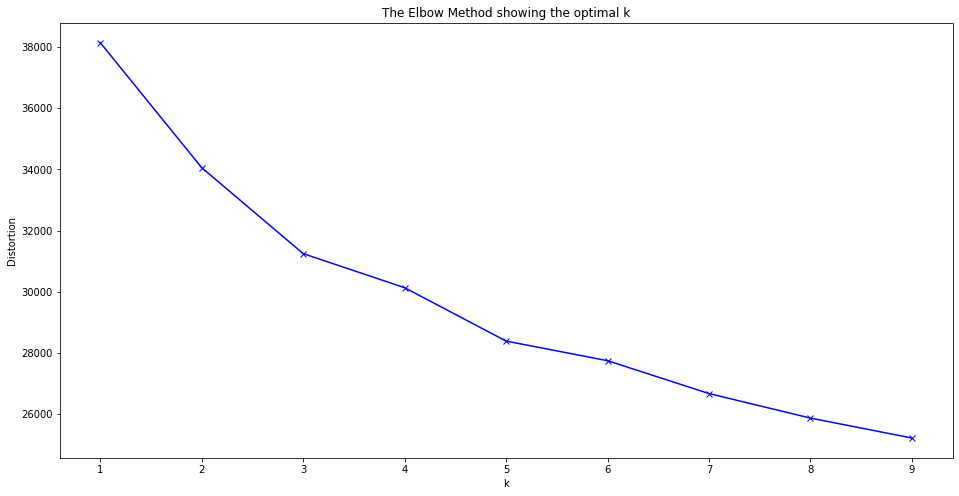

In [61]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny_grouped_x)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the above plot we choose a K = 5 to start the analysis. The K =3 seemed also like a good approach but we wanted to have a more uniform distribution of all our 302 neighborhoods.

##### Clustering algorithm - K-means

In [62]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 1, 1, 1, 1, 0, 1, 3, 3], dtype=int32)

In [63]:
kmeans.labels_

array([3, 1, 1, 1, 1, 1, 0, 1, 3, 3, 4, 0, 3, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       3, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 4, 1, 3, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 4, 0, 1, 3, 4, 1, 1, 1, 4, 0, 3, 0, 3, 1, 3, 3, 1,
       3, 3, 0, 3, 3, 3, 1, 0, 4, 3, 3, 1, 0, 1, 3, 0, 0, 3, 3, 1, 1, 1,
       3, 0, 3, 1, 3, 1, 1, 4, 3, 4, 3, 3, 1, 3, 0, 0, 0, 0, 1, 3, 4, 3,
       1, 1, 1, 0, 0, 3, 3, 1, 3, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1,
       3, 3, 1, 4, 1, 4, 1, 0, 0, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 4,
       3, 0, 1, 4, 3, 0, 3, 1, 1, 3, 0, 0, 1, 3, 3, 1, 3, 3, 3, 1, 4, 4,
       3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 3, 1, 0, 3, 1, 0, 3,
       1, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 0, 3,
       3, 1, 1, 4, 1, 0, 4, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       3, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 0,
       3, 0, 3, 4, 1, 1, 1, 1, 1, 4, 4, 4, 3, 3, 0, 0, 3, 3, 4, 3, 0, 3,
       3, 1, 0, 3, 1, 3, 3, 0, 1, 0, 3, 3, 1, 1, 0,

In [65]:
len(kmeans.labels_)

302

In [64]:
pd.DataFrame(kmeans.labels_)[0].value_counts()

1    123
3    102
0     53
4     23
2      1
Name: 0, dtype: int64

Add the resultant labels the our final dataset.

In [67]:
ny_grouped['Cluster Labels'] = pd.DataFrame(kmeans.labels_)[0]

In [68]:
merged=pd.merge(ny_grouped,ny_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']].drop_duplicates(),on='Neighborhood')

In [69]:
merged.iloc[:,0:-2].drop_duplicates().index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            296, 297, 298, 299, 300, 301, 302, 303, 304, 305],
           dtype='int64', length=302)

In [70]:
merged=merged.iloc[merged.iloc[:,0:-2].drop_duplicates().index]

Let's visualize the neighbours by cluster label

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Neighborhood Latitude'], merged['Neighborhood Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Analyze each cluster

To analyze each cluster in order to answer all our initial questions we need to find the mean number of gyms and fast food in general and compare to the values achieved for each cluster.

Mean and standard deviation of the number of gyms in New York city:

In [72]:
ny_grouped['Gym'].mean()

0.8675496688741722

In [73]:
ny_grouped['Gym'].std()

1.3624069802804275

Mean and standard deviation of the number of fast food restaurants in New York city:

In [74]:
ny_grouped['Fast Food'].mean()

4.347682119205298

In [75]:
ny_grouped['Fast Food'].std()

3.0195890776096364

##### Cluster 0

In [77]:
describe_cluster0 = merged[merged['Cluster Labels']==0].iloc[:,1:-2].describe()

In [78]:
describe_cluster0['Gym']

count    53.000000
mean      1.283019
std       1.349891
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       5.000000
Name: Gym, dtype: float64

In [79]:
describe_cluster0['Fast Food']

count    53.000000
mean      3.905660
std       1.832024
min       1.000000
25%       3.000000
50%       3.000000
75%       5.000000
max       8.000000
Name: Fast Food, dtype: float64

##### Cluster 1

In [80]:
describe_cluster1 = merged[merged['Cluster Labels']==1].iloc[:,1:-2].describe()

In [81]:
describe_cluster1['Gym']

count    123.000000
mean       0.373984
std        0.657845
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: Gym, dtype: float64

In [82]:
describe_cluster1['Fast Food']

count    123.000000
mean       2.479675
std        1.780355
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        6.000000
Name: Fast Food, dtype: float64

Where the neighborhoods from cluster 1 are situated?

In [109]:
new_york_data['Borough'][new_york_data['Neighborhood'].isin(merged['Neighborhood'][merged['Cluster Labels']==1])].value_counts()

Staten Island    53
Queens           39
Bronx            18
Brooklyn         13
Name: Borough, dtype: int64

##### Cluster 2

In [83]:
describe_cluster2 = merged[merged['Cluster Labels']==2].iloc[:,1:-2].describe()

In [84]:
describe_cluster2['Gym']

count    1.0
mean     4.0
std      NaN
min      4.0
25%      4.0
50%      4.0
75%      4.0
max      4.0
Name: Gym, dtype: float64

In [85]:
describe_cluster2['Fast Food']

count    1.0
mean     9.0
std      NaN
min      9.0
25%      9.0
50%      9.0
75%      9.0
max      9.0
Name: Fast Food, dtype: float64

##### Cluster 3

In [108]:
new_york_data['Borough'][new_york_data['Neighborhood'].isin(merged['Neighborhood'][merged['Cluster Labels']==2])].value_counts()

Manhattan    1
Queens       1
Name: Borough, dtype: int64

In [86]:
describe_cluster3= merged[merged['Cluster Labels']==3].iloc[:,1:-2].describe()

In [87]:
describe_cluster3['Gym']

count    102.000000
mean       0.705882
std        0.839475
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: Gym, dtype: float64

In [88]:
describe_cluster3['Fast Food']

count    102.000000
mean       7.352941
std        2.476212
min        3.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       15.000000
Name: Fast Food, dtype: float64

In [98]:
merged['Neighborhood'][merged['Cluster Labels']==3]

0                Allerton
8              Auburndale
9              Bath Beach
12            Bay Terrace
14             Baychester
              ...        
293    Westchester Square
295            Whitestone
296        Williamsbridge
300               Wingate
301             Woodhaven
Name: Neighborhood, Length: 102, dtype: object

Where the neighborhoods from cluster 3 are situated?

In [106]:
new_york_data['Borough'][new_york_data['Neighborhood'].isin(merged['Neighborhood'][merged['Cluster Labels']==3])].value_counts()

Bronx            34
Brooklyn         32
Queens           28
Staten Island     9
Manhattan         1
Name: Borough, dtype: int64

##### Cluster 4

In [89]:
describe_cluster4 = merged[merged['Cluster Labels']==4].iloc[:,1:-2].describe()

In [90]:
describe_cluster4['Gym']

count    23.000000
mean      3.130435
std       2.784769
min       0.000000
25%       1.000000
50%       2.000000
75%       5.500000
max      11.000000
Name: Gym, dtype: float64

In [91]:
describe_cluster4['Fast Food']

count    23.000000
mean      1.826087
std       1.266785
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Fast Food, dtype: float64

Where the neighborhoods from cluster 4 are situated?

In [107]:
new_york_data['Borough'][new_york_data['Neighborhood'].isin(merged['Neighborhood'][merged['Cluster Labels']==4])].value_counts()

Manhattan        15
Brooklyn          5
Queens            3
Staten Island     1
Name: Borough, dtype: int64

By analyzing the results we can see that the worst cluster is number 3 because it has a low mean number of gyms and a high mean number of fast food restaurants. The best cluster would be 4 because it has high mean number of gyms and low mean number of fast food restaurants. We can see that most of the neighborhoods in cluster 3 are distributed in Bronx, Queen and Brooklyn and most neighborhoods in cluster 4 are distributed in Manhattan. The cluster with lower mean number of gyms is cluster 1 that have most of its neighborhoods distributed in Staten Island.
Summing up, to answer to the initial question that are left, for a person that likes gyms and lives a healthy lifestyle, the best neighborhoods to live are from neighborhoods from the cluster 4, specially in Manhattan and if we want to open a new gym cluster 1 would be a good option, specially in Staten Island.